# Project Introduction 

Cancer is a global issue that transcends borders, impacting individuals from diverse backgrounds. Its prevalence has reached a point where nearly everyone either has a personal connection to someone affected by cancer or has faced this formidable adversary themselves. Moreover, the intricate process of accurately detecting cancers is time-consuming and relies on the expertise of healthcare professionals who may, regrettably, occasionally misdiagnose or, in some cases, not be readily available to offer timely assistance. These factors invariably cast a shadow over the quality of life and life expectancy of those affected. Early detection of malignant tumors holds the key to initiating treatment promptly and significantly enhancing the prognosis of the disease. This is precisely where the field of machine learning shines as a promising ally in the battle against cancer.

# Methodology

Over time, a compelling observation has emerged, revealing hidden patterns among individuals grappling with various types of cancer. Concurrently, deep learning networks have proven their prowess in deciphering intricate patterns that elude the naked eye. Consequently, the primary objective of this undertaking is to proficiently discern and classify images of Breast Lesions into one of the following categories:

* benign  
* malignant
* normal 

This will be done through utilising "Breast Ultrasound Images Dataset" a public licenced dataset hosted by kaggle.


To achieve this, we will harness the "Breast Ultrasound Images Dataset," an openly accessible and licensed dataset hosted on Kaggle, as a valuable resource. The dataset will serve as the foundation for our endeavor, and we will employ a combination of Python, TensorFlow, and Keras in our toolkit. Our mission is to cultivate a robust deep learning network capable of meticulously capturing the underlying patterns within cancer images. The project adheres to a deductive approach, embarking on the design and construction of deep learning networks, commencing with a model that surpasses conventional baseline expectations.

* URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset. 

### Dataset Description

* The dataset is available on Kaggle at the following link: www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset . 


* This dataset was compiled in 2018 and comprises breast ultrasound images of female individuals aged between 25 and 75 years old. It encompasses a total of 600 female patients and includes 780 images, each with an average size of 500x500 pixels, and they are stored in the PNG format. For clarity, each original image is accompanied by its corresponding ground truth image. The images have been categorized into three distinct classes: normal, benign, and malignant.

The following Python packages will be extensively used to model and display the images

### Python Modules Instalation

In [98]:
# To install inside the jupiter notebook remove both """
"""
# Install TensorFlow
!pip install tensorflow
# Install NumPy
!pip install numpy
#Install Matplotlib
!pip install matplotlib
#Install Seaborn
!pip install seaborn

"""

'\n# Install TensorFlow\n!pip install tensorflow\n# Install NumPy\n!pip install numpy\n#Install Matplotlib\n!pip install matplotlib\n#Install Seaborn\n!pip install seaborn\n\n'

### Python Modules

In [99]:
# system
import os
import pathlib

# Mathematical Computation
import numpy as np

# Machine Learning Library
import tensorflow as tf 

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


The subsequent utility functions were employed to transform the data into a suitable format for TensorFlow, facilitate the output of a graph-based learning model, and decode the images for effortless visualization.

### Helper Functions

In [179]:
             
#************************************* Image Processing ************************************************#

# Function to decode an image from a file path
def image_decoding(file_path):
    """
    Decode an image from a file path, normalize it, resize it to (250, 250) pixels,
    and convert it from grayscale to RGB format if needed.

    Args:
        file_path (str): The path to the image file.

    Returns:
        tf.Tensor: The decoded and preprocessed image.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    
    # Normalize the image to the range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0 
    img = tf.image.resize(img, (250, 250))
    
    # Convert image from grayscale to RGB (if needed)
    if tf.shape(img)[2] == tf.convert_to_tensor(1): 
        img = tf.image.grayscale_to_rgb(img)
    
    return img

# Function to convert file path to image and class label
def convert_file_to_image_and_label(file_path):
    """
    Convert a file path to an image and its corresponding class label.

    Args:
        file_path (str): The path to the image file.

    Returns:
        tf.Tensor: The decoded and preprocessed image.
        int: The class label (0 for normal, 1 for benign, 2 for malignant).
    """
    img = image_decoding(file_path)
    label = tf.strings.split(file_path, os.path.sep)[-2] == class_labels
    return img, tf.argmax(label)


         
#************************************* Image Display ************************************************#

# Set the style for drawing grids on image displays
sns.set(style="whitegrid")

# Function to display a single image with a class label
def display_single_image(img, label):
    """
    Display a single image along with its class label.

    Args:
        img (tf.Tensor): The image to be displayed.
        label (str): The class label for the image.
    """
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')  # Turn off axis labels and ticks

# Function to display a grid of sample images with class labels
def display_image_batch(image_batch, label_batch, num_samples):
    """
    Display a grid of sample images along with their class labels.

    Args:
        image_batch (tf.Tensor): A batch of images to be displayed.
        label_batch (list): A list of class labels corresponding to the images.
        num_samples (int, optional): Number of samples to display in the grid. Default is 16.
    """
    figure = plt.figure(figsize=(12, 10))
    rows = int(num_samples ** 0.5)
    cols = rows
    for i in range(num_samples):
        ax = plt.subplot(rows, cols, i + 1)
        display_single_image(image_batch[i], class_labels[label_batch[i]])
    
    plt.tight_layout()
    plt.show()


#************************************* Dataset Orginisation ************************************************#

# Function to configure a dataset for training
def configure_dataset_for_training(dataset):
    """
    Configure a dataset for training by caching, shuffling, batching, and prefetching.

    Args:
        dataset (tf.data.Dataset): The input dataset.
        is_trained (bool, optional): Set to True if configuring for training (default is False).

    Returns:
        tf.data.Dataset: The configured dataset.
    """
    # Cache the dataset for improved performance
    dataset = dataset.cache()
    
    # Shuffle the dataset (buffer size can be adjusted)
    dataset = dataset.shuffle(buffer_size=300)
    
    # Batch the data (adjust batch size as needed)
    dataset = dataset.batch(32)
    
    # Optionally perform data augmentations if it's for training
    #if is_trained:
        # Perform data augmentations here
    #    pass
    
    # Prefetch data for better pipeline performance
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

#*************************************  Callback functions ************************************************#


class CustomTrainingCallback(tf.keras.callbacks.Callback):
    """
    A custom callback that displays a spinning icon to provide visual feedback
    during the training process.
    """

    def on_epoch_begin(self, epoch, logs=None):
        # Define a sequence of spinning icons
        spinning_icons = ['\b|', '\b/', '\b-', '\b\\']
        # Print the spinning icon corresponding to the current epoch
        print(spinning_icons[epoch % 4], end='')

    def on_epoch_end(self, epoch, logs=None):
        # Erase the spinning icon at the end of the epoch
        print('\b', end='')

# Early Stopping Callback
# early_stopper = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     verbose=0,
#     mode='auto',
#     restore_best_weights=True
# )

# Model Checkpoint Callback to Save Best Model
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     mode='min',
#     verbose=0
# )


           
#*************************************  Ploting the Model Output************************************************#

# Function to visualize training and validation losses
def visualize_training_losses(history):
    """
    Visualize the training and validation losses over epochs.

    Args:
        history (dict): A dictionary containing training and validation loss values.
        num_epochs (int): The total number of training epochs.
    """
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    
    num_epochs = [i for i in range(EPOCHS)]
    
    plt.plot(num_epochs, train_loss, label="Training Loss", color="b")
    plt.plot(num_epochs, val_loss, label="Validation Loss", color="r")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

# Function to visualize training and validation accuracies
def visualize_training_accuracies(history):
    """
    Visualize the training and validation accuracies over epochs.

    Args:
        history (dict): A dictionary containing training and validation accuracy values.
        num_epochs (int): The total number of training epochs.
    """
    train_accuracy = history["acc"]
    val_accuracy = history["val_acc"]
    
    num_epochs = [i for i in range(EPOCHS)]
    
    plt.plot(num_epochs, train_accuracy, label="Training Accuracy", color="b")
    plt.plot(num_epochs, val_accuracy, label="Validation Accuracy", color="r")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Dataset Uploading 

In [101]:
# Define the directory path containing the dataset
dataset_directory = "./Dataset_BUSI_with_GT"

# Obtain the image dataset from local storage
# Select real images only; mask images have filenames ending in "_mask.png"
image_dataset = tf.data.Dataset.list_files(
    str(pathlib.Path(dataset_directory) /"*/*).png"),
    shuffle='False'
)


### Investigating the Image Dataset

Analyzing the quantity of accessible data samples within the dataset.


In [102]:
# Determine the number of images in the dataset
dataset_size = len(image_dataset)

# Display the total count of images in the dataset
print(f"The dataset contains a total of {dataset_size} images.")

The dataset contains a total of 780 images.


In the preceding cell, it's apparent that the dataset comprises a total of 1,578 images. Given the relatively limited number of images available, employing k-fold cross-validation emerges as an optimal strategy for training our deep learning model. However, to establish a baseline and facilitate testing, we will initially adopt a hold-out validation approach, partitioning the dataset into separate training and testing sets.


Examining a limited subset of the loaded image file paths and their corresponding class labels from the dataset. This exploration aims to provide insights into the existing data structure and gain a preliminary understanding of its composition.

In [103]:
# View a sample image and its class label
for image in image_dataset.take(1):
    # Display the image data
    print("Sample image data:\n", image.numpy())

    # Extract the class label from the file path
    class_label = tf.strings.split(image, os.path.sep)[-2].numpy()
    print("\nThis image belongs to the class:", class_label, "\n")

# View available class labels and their count
class_labels = os.listdir(dataset_directory)
num_class_labels = len(class_labels)
print("\nThere are", num_class_labels, "unique class labels available:", class_labels, "\n")

Sample image data:
 b'Dataset_BUSI_with_GT\\benign\\benign (194).png'

This image belongs to the class: b'benign' 


There are 3 unique class labels available: ['benign', 'malignant', 'normal'] 



Since there are three distinct classifications, but each instance can belong to only one category, we are presented with a multiclass single-label classification challenge. Consequently, when constructing our model, we will employ a "softmax" activation function in the final layer, complemented by a "categorical cross-entropy" loss function to effectively address this classification task.

Currently, the dataset comprises a series of PNG images with dimensions of approximately 550 by 450 pixels. This file size is relatively large and necessitates conversion to a smaller scale of 250 by 250 pixels. Additionally, to seamlessly integrate with TensorFlow, the PNG format must be transformed into tensors. To accomplish this, two utility functions have been devised, working in tandem through list comprehension. These functions resize the images, convert them into tensors, and associate each with a class label represented as an integer. Ultimately, they return the processed dataset.

Given that image loading and conversion can be resource-intensive, the Keras API offers a practical capability to manage and optimize data retrieval in the background for improved computational efficiency.

In [104]:
data = image_dataset.map(convert_file_to_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

Let's take a glimpse at a portion of the freshly transformed dataset to get a better visual representation of its new format.

In [105]:
for image, label in data.take(2):
    class_label = class_labels[label.numpy()]
    print("Label: {}, Class: {}".format(label.numpy(), class_label))
    print("Image Tensor:\n", image)

Label: 0, Class: benign
Image Tensor:
 tf.Tensor(
[[[0.1196003  0.1196003  0.1196003 ]
  [0.262892   0.262892   0.262892  ]
  [0.18919554 0.18919554 0.18919554]
  ...
  [0.97034925 0.97034925 0.97034925]
  [0.95535666 0.95535666 0.95535666]
  [0.89281815 0.89281815 0.89281815]]

 [[0.12692799 0.12692799 0.12692799]
  [0.390745   0.390745   0.390745  ]
  [0.41991082 0.41991082 0.41991082]
  ...
  [0.9066586  0.9066586  0.9066586 ]
  [0.9209416  0.9209416  0.9209416 ]
  [0.85905623 0.85905623 0.85905623]]

 [[0.15190558 0.15190558 0.15190558]
  [0.39289823 0.39289823 0.39289823]
  [0.7724432  0.7724432  0.7724432 ]
  ...
  [0.8397592  0.8397592  0.8397592 ]
  [0.8441257  0.8441257  0.8441257 ]
  [0.8474882  0.8474882  0.8474882 ]]

 ...

 [[0.2928111  0.2928111  0.2928111 ]
  [0.26948    0.26948    0.26948   ]
  [0.25925487 0.25925487 0.25925487]
  ...
  [0.21963029 0.21963029 0.21963029]
  [0.22470693 0.22470693 0.22470693]
  [0.2271024  0.2271024  0.2271024 ]]

 [[0.26265895 0.26265895

At this point, the data is appropriately structured. Nevertheless, there remains a crucial step: splitting the data into training, testing, and validation sets. These sets will serve as the foundation for establishing a baseline learning model. The objective for this initial model is modest—it should surpass a 33% accuracy threshold, which corresponds to randomly assigning an image to one of the three class labels.

In [106]:
# Splitting the dataset into training and testing sets
size_data_test = int(dataset_size * 0.3)  # Define the size of the testing set
training_data = data.skip(size_data_test)  # Training data excludes the testing set
testing_data = data.take(size_data_test)    # Testing data includes a portion of the dataset

# Display the sizes of the training and testing datasets
print('Training dataset size:', len(training_data))
print('Testing dataset size:', len(testing_data))


Training dataset size: 546
Testing dataset size: 234


In [107]:
training_data = configure_dataset_for_training(training_data, is_trained=True)
testing_data = configure_dataset_for_training(testing_data, is_trained=True)

#### Visualizing a subset of images from the processed dataset to assess data representation.


The Image Batch Shape -> (32, 250, 250, 3) 

The Label Batch Shape -> (32,)
The Image Batch Shape -> (32, 250, 250, 3) 

The Label Batch Shape -> (32,)


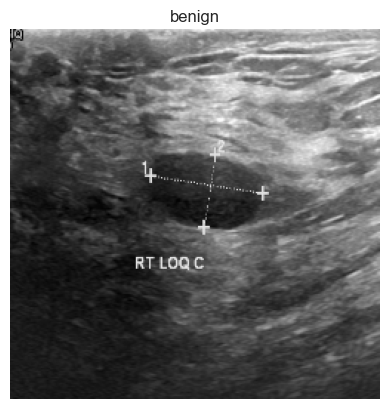

In [108]:
for image_batch, label_batch in training_data.take(2):
    print("The Image Batch Shape ->",image_batch.shape,"\n")
    print("The Label Batch Shape ->",label_batch.shape)
display_single_image(image_batch.numpy()[0], class_labels[label_batch.numpy()[0]])

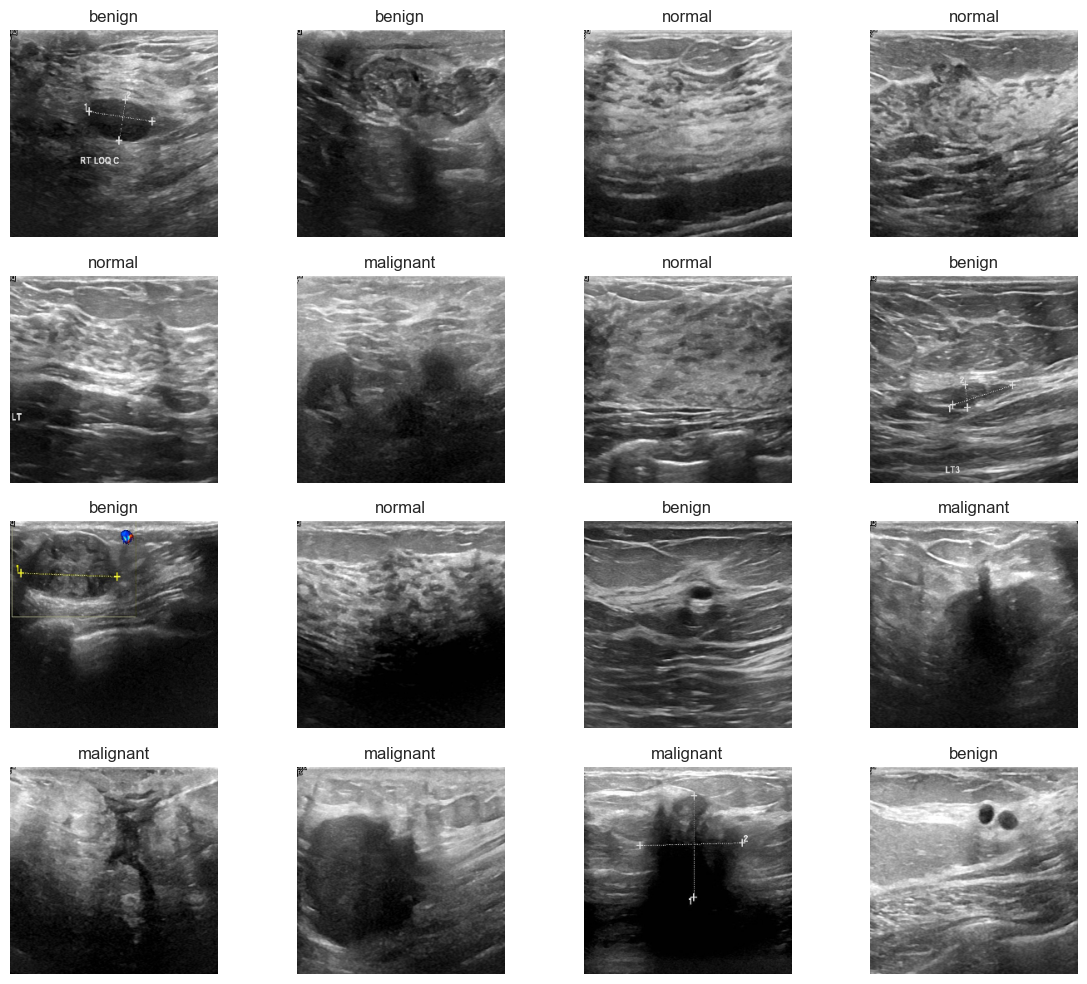

In [109]:
# Available to change 16 to 4 
display_image_batch(image_batch, label_batch, 16)


### Base Model to Build the Network

When constructing the foundational model, we will initiate with a straightforward hold-out validation configuration of the dataset (training data and test data). The primary objective is to evaluate the most basic system's predictive accuracy. As previously mentioned, this model is only required to achieve an accuracy exceeding 33%, which corresponds to the accuracy of a model making random guesses among the three class labels.

In [121]:

# ******************* Building the Baseline Image Classification Model **********************
def create_image_classification_model():
    # Define the input layer with an input shape of (250, 250, 3)
    image_input = tf.keras.layers.Input(shape=(250, 250, 3))

    # Convolutional layer with 32 filters, a kernel size of (3,3), ReLU activation, and 'valid' padding
    conv1 = tf.keras.layers.Conv2D(filters=32, 
                                   kernel_size=(2, 2),
                                   strides=(1, 1),
                                   padding='valid',
                                   activation='relu')(image_input)

    # MaxPooling layer with a pool size of (2, 2)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Global Average Pooling layer
    global_avgpool = tf.keras.layers.GlobalAveragePooling2D()(maxpool1)

    # Output layer with 'num_class_labels' classes and softmax activation
    output = tf.keras.layers.Dense(num_class_labels, activation='softmax')(global_avgpool)

    # Create and return the image classification model
    model = tf.keras.models.Model(inputs=image_input, outputs=output)
    return model


In [122]:
create_image_classification_model = create_image_classification_model()
create_image_classification_model.compile(optimizer='adam', 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['acc'])
create_image_classification_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 249, 249, 32)      416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_6  (None, 32)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)

The model summary reveals that there are a total of 515  trainable parameters dedicated to capturing the underlying patterns within the dataset.

In [135]:
EPOCHS = 4
BATCH_SIZE = 32

In [136]:
# Training the Image Classification Model
# - `training_history` will store the training progress, including loss and accuracy.
# - We are using the `fit` method to train the model.
training_history  = create_image_classification_model.fit( 
                    # - `training_data` is the training dataset.
                    training_data,
                    
                    # - `validation_data` is the validation dataset used to monitor model performance.
                    validation_data=testing_data,
                    
                    # - `epochs` specifies the number of training iterations over the entire dataset.
                    epochs=EPOCHS,
                    
                    # - `batch_size` determines the number of samples processed in each training step.
                    batch_size=BATCH_SIZE,
                    
                    # - `verbose` set to 0 means no output during training; set to 1 or 2 for more details.
                    verbose=0,

                    # - `callbacks` is a list of custom callbacks to execute during training, if any.
                    callbacks=[CustomTrainingCallback()])

In [137]:

_, training_accuracy = create_image_classification_model.evaluate(training_data, verbose=0)
_, testing_accuracy = create_image_classification_model.evaluate(testing_data, verbose=0)
print('Accuracy on Training Data: %.5f, Accuracy on Testing Data: %.5f' % (training_accuracy, testing_accuracy))

Training accuracy: 0.56593, Testing accuracy: 0.56838


From the preceding cell, it is evident that when assessing the baseline model, it achieved a test accuracy considerably surpassing the basic expectation of approximately 30%.


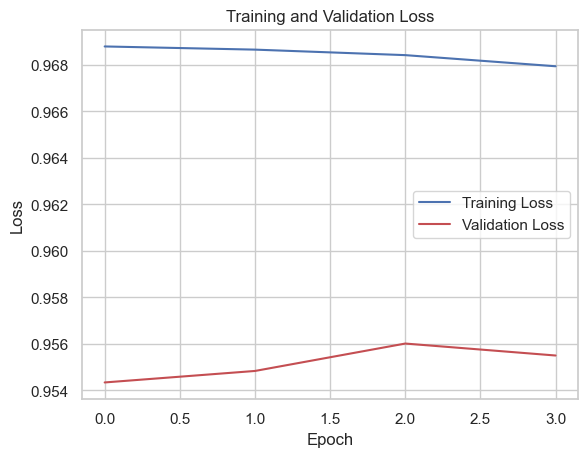

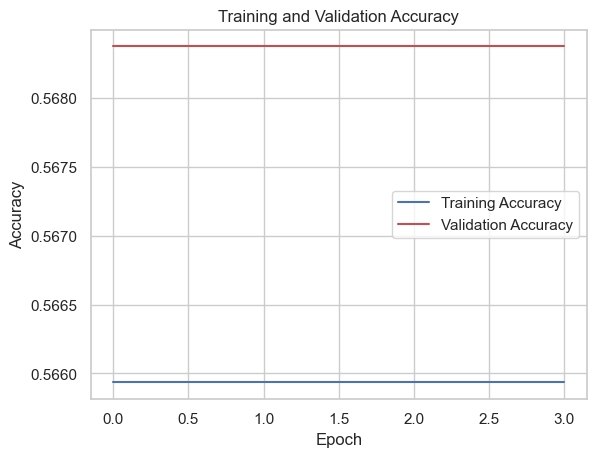

In [138]:
visualize_training_losses(training_history.history)
visualize_training_accuracies(training_history.history)

However, upon examining the plotted training and validation metrics, including loss and accuracy, it becomes evident that the model had not yet reached convergence, which is the point at which the validation loss and training loss stabilize before any overfitting occurs. To identify this convergence point, the number of training epochs will be extended to 600.


### Training for a Massive Epochs Cycles

In [143]:
EPOCHS = 400

In [144]:
history = create_image_classification_model.fit( 
                    training_data,
                    validation_data=testing_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomTrainingCallback()])

In [145]:
_, training_accuracy = create_image_classification_model.evaluate(training_data, verbose=0)
_, testing_accuracy = create_image_classification_model.evaluate(testing_data, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (training_accuracy, testing_accuracy))

Training accuracy: 0.570, Testing accuracy: 0.564



Observing the testing accuracy, it becomes apparent that despite the substantial increase in the number of training epochs, there hasn't been a significant improvement in accuracy. This hints at the possibility that the model may either be inadequately sized or require an even longer training duration. To gain deeper insights into the model's performance, we will visualize the training and validation loss and accuracy through graphical representation.


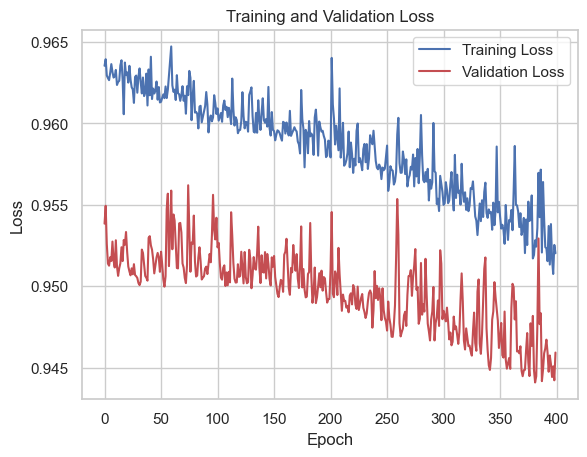

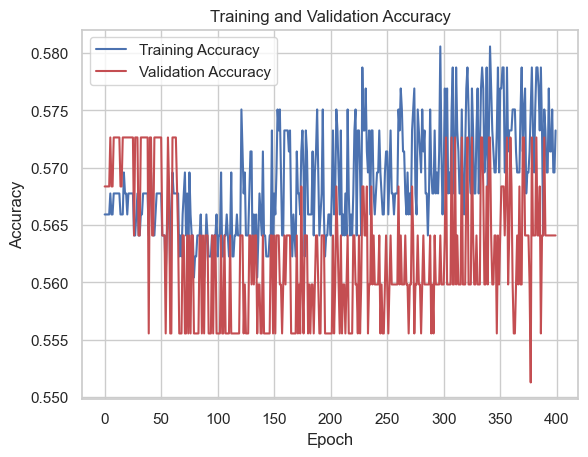

The worst Validation Loss happen at the 381 epoch


In [146]:
visualize_training_losses(history.history)
visualize_training_accuracies(history.history)
BEST_EPOCH = np.argmin(history.history['val_loss'])
print('The worst Validation Loss happen at the', BEST_EPOCH, 'epoch')


Based on the plotted results, it's evident that the model's convergence is progressing at a relatively slow pace. Additionally, there is noticeable noise in the training process. To address these challenges and expedite convergence, we plan to enhance the model by incorporating a second convolutional layer and replacing the global average pooling layer with a flatten layer.

### Building a Bigger Model

In [159]:
def model():
    inputs = tf.keras.layers.Input(shape=(250,250,3))

    x = tf.keras.layers.Conv2D(filters=32, 
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)
    
    x = tf.keras.layers.Conv2D(filters=32, 
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)

#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(32, activation='relu')(x)
    
    x = tf.keras.layers.Flatten()(x)

    outputs = tf.keras.layers.Dense(num_class_labels, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [160]:
model = model()
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 247, 247, 32)      1568      
                                                                 
 conv2d_12 (Conv2D)          (None, 244, 244, 32)      16416     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 122, 122, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 476288)            0         
                                                                 
 dense_9 (Dense)             (None, 3)                 1428867   
                                                           

Analyzing the model summary, it becomes evident that the modest adjustment in the model's architecture has led to a notable increase in the count of trainable parameters. This augmentation suggests that the model is likely to reach convergence more rapidly. To align with this expectation, we plan to reduce the number of training epochs to 100.

In [161]:
EPOCHS = 50

In [162]:
training_history = model.fit(training_data,
                    validation_data=testing_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomTrainingCallback()])

In [163]:
_, training_accuracy = model.evaluate(training_data, verbose=0)
_, testing_accuracy = model.evaluate(testing_data, verbose=0)
print('Training accuracy: %.3f, Testing accuracy: %.3f' % (training_accuracy, testing_accuracy))

Training accuracy: 0.998, Testing accuracy: 0.885


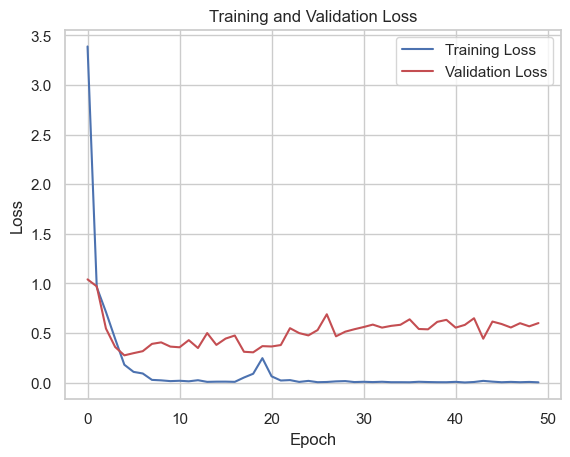

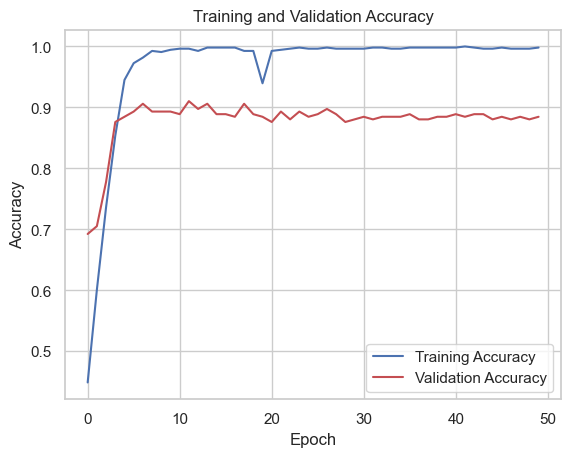

In [164]:
visualize_training_losses(training_history.history)
visualize_training_accuracies(training_history.history)

We will conduct a second training session for the model to explore whether consistent outcomes are observed or if the model exhibits sensitivity to the dataset's size.

In [165]:
history = model.fit(training_data,
                    validation_data=testing_data,
                    epochs=EPOCHS,  
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    callbacks=[CustomTrainingCallback()])

In [167]:
_, training_accuracy = model.evaluate(training_data, verbose=0)
_, testing_accuracy = model.evaluate(testing_data, verbose=0)
print('Training accuracy: %.5f, Testing accuracy: %.5f' % (training_accuracy, testing_accuracy))

Training accuracy: 0.99817, Testing accuracy: 0.88889


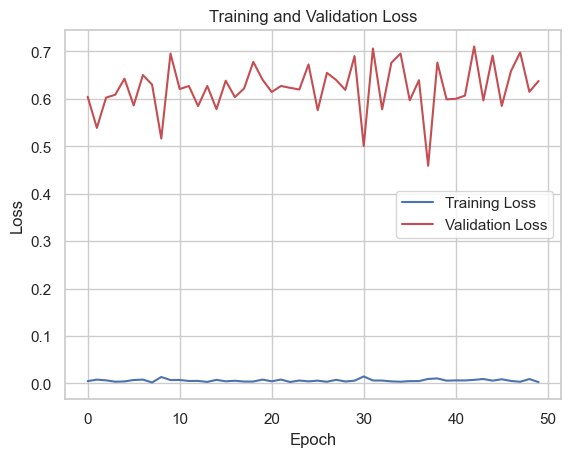

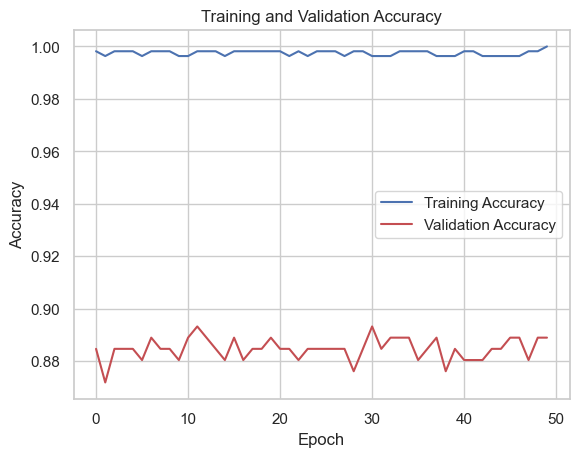

The lowest Validation Loss occured in the 37 epoch


In [168]:
visualize_training_losses(history.history)
visualize_training_accuracies(history.history)
BEST_EPOCH = np.argmin(history.history['val_loss'])
print('The lowest Validation Loss occured in the', BEST_EPOCH, 'epoch')

After running the model twice and assessing the training and validation metrics up to 50 epochs,the significant gap between the training accuracy (almost 100%) and testing accuracy (88.89%) suggests that the model might be overfitting to some extent.. This suggests that the model exhibits sensitivity to the dataset's composition. To address this challenge, we will transition to a k-fold validation approach.

In [169]:
# we split the dataset
size_data_test = int(dataset_size * 0.2)
training_data = data.skip(size_data_test)
testing_data = data.take(size_data_test)

### K Fold Validation

In [180]:
# Number of folds for k-fold cross-validation
num_folds = 4

# Calculate the number of samples per fold
samples_per_fold = len(training_data) // num_folds

# Lists to store loss and accuracy history for each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for fold in range(num_folds):
    print('Processing fold', fold)
    
    # Calculate the range for the current validation set
    val_start = fold * samples_per_fold
    val_end = (fold + 1) * samples_per_fold
    
    # Split the dataset into training and validation sets using skip and take
    val_data = training_data.skip(val_start).take(samples_per_fold)
    partial_training_data = training_data.take(val_start).concatenate(training_data.skip(val_end))
    
    # Configure datasets for training
    partial_training_data = configure_dataset_for_training(partial_training_data)
    val_data = configure_dataset_for_training(val_data)

    
    # Train the model on the current fold
    history = create_image_classification_model.fit(
        partial_training_data,
        validation_data=val_data,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    # Evaluate the model on the training and validation data
    _, train_accuracy = create_image_classification_model.evaluate(partial_training_data, verbose=0)
    _, val_accuracy = create_image_classification_model.evaluate(val_data, verbose=0)
    
    # Extract loss and accuracy history for the current fold
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    train_acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    
    # Append the history to the respective lists
    all_train_losses.append(train_loss_history)
    all_val_losses.append(val_loss_history)
    all_train_accuracies.append(train_acc_history)
    all_val_accuracies.append(val_acc_history)


Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


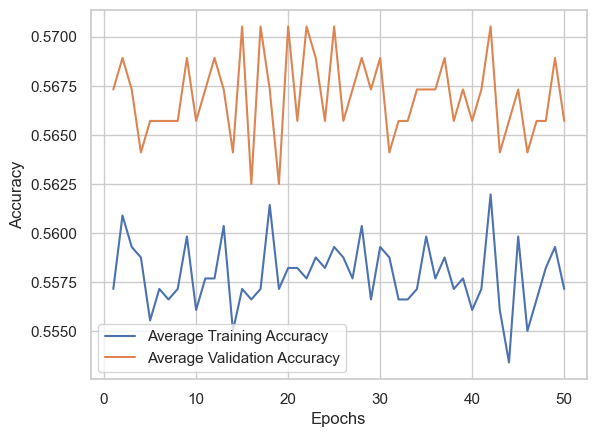

In [181]:

# Calculate average training and validation loss and accuracy over epochs
average_train_loss_history = [np.mean([x[i] for x in all_train_losses]) for i in range(EPOCHS)]
average_val_loss_history = [np.mean([x[i] for x in all_val_losses]) for i in range(EPOCHS)]
average_train_acc_history = [np.mean([x[i] for x in all_train_accuracies]) for i in range(EPOCHS)]
average_val_acc_history = [np.mean([x[i] for x in all_val_accuracies]) for i in range(EPOCHS)]

# Plot the average training and validation accuracy over epochs
plt.plot(range(1, len(average_train_acc_history) + 1), average_train_acc_history, label='Average Training Accuracy')
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

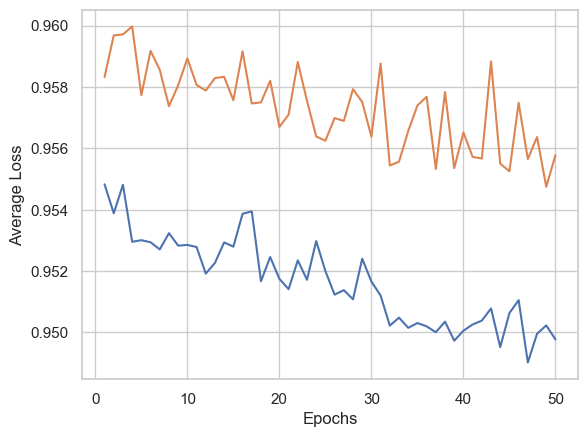

In [182]:
plt.plot(range(1, len(average_train_loss_history) + 1), average_train_loss_history)
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')

plt.show()

When we observe significantly lower training accuracy (e.g., 0.557) during k-fold cross-validation compared to what you reported earlier (almost 100% training accuracy), it suggests that your model is not overfitting as severely as previously suspected. In fact, this discrepancy in training accuracy values between k-fold cross-validation and the previous training likely indicates that the model is learning better during cross-validation.

### Building the Final Model

In [184]:
EPOCHS = 6
# we split the dataset
size_data_test = int(dataset_size * 0.2)
training_data = data.skip(size_data_test)
testing_data = data.take(size_data_test)

training_data = configure_dataset_for_training(training_data)
testing_data = configure_dataset_for_training(testing_data)

In [185]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'])
model.fit(training_data, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=0, 
          callbacks=[CustomTrainingCallback()])


In [186]:
_, testing_accuracy = model.evaluate(testing_data, verbose=0)

In [187]:
print('The final training outcome', testing_accuracy)

The final training outcome 0.9871794581413269


# Results

The model's high accuracy on the test data is a little bit  concerning, but when i apply the k fold validation, the result were good to make sure there is no overdrifting.

Nevertheless, since the dataset is small and has three classes, an imbalanced dataset is likely to happen in the future. To confirm this, we can examine the class distribution counts.

In [188]:
for i in range(num_class_labels):
    count = 0
    _dir = os.listdir(dataset_directory +"\\"+class_labels[i])
    for root, dirs, files in os.walk(dataset_directory):
        for file in files: 
            if file.endswith(').png'):
                if file.startswith(class_labels[i]):
                    count += 1    
    print('\n',"There are",count,"data points available in class:", class_labels[i],'\n')


 There are 437 data points available in class: benign 


 There are 210 data points available in class: malignant 


 There are 133 data points available in class: normal 




Yes, there are several disadvantages associated with unbalanced datasets where some classes have significantly fewer samples than others. Here are some of the main disadvantages like Biased Model Training, Poor Generalization, Misleading Evaluation, Class Imbalance Costs, Increased Sensitivity to Noise, etc.

Here are four ways to address this issue in the future and create a database more sutable for this process:

**Geting a larger dataset:** This is the best solution, but it may not always be possible.

**Undersample the benign class:**  This involves randomly removing data points from the benign class. However, this can lead to the loss of important information, so it is not a good option for this dataset.

**Oversample the minority classes :** This involves duplicating data points from the minority classes. However, this can lead to overfitting, so it is important to use it carefully.

**Generate synthetic data :** This involves creating new data points by sampling from existing data. However, this can be computationally expensive for image datasets.

Given the characteristics of this dataset, oversampling is the most suitable solution, even though it carries a risk of overfitting.

# Conclusion


The deep learning model achieves a certain level of accuracy in identifying breast cancer lesions; however, it is not 100% accurate due to compatibility issues between the model and the database.

deep learning has the potential to be a powerful tool for cancer identification. To fully realize this potential, we need to either collect a larger and more balanced dataset or develop effective preprocessing techniques to balance the dataset.

# Refrences

Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863. Accessed 18 Sep 2023.
    * https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
    
Vickery, R. (2020) Beginners Guide to Deep Learning with tensorflow, Medium. Available at: https://towardsdatascience.com/beginners-guide-to-deep-learning-with-tensorflow-ca85969b2f2 (Accessed: 18 September 2023). 

D.R. (1963) How to perform K-fold Cross Validation with tensorflow?, Stack Overflow. Available at: https://stackoverflow.com/questions/39748660/how-to-perform-k-fold-cross-validation-with-tensorflow (Accessed: 18 September 2023). 

